In [1]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import AdaMaskBINNCovasim
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, plot_loss_convergence #, AIC_OLS, RSS

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [3]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'

population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 3
multiple = True
parallelb = True
n_runs = 64
chi_type = 'piecewise'

# model parameters
maskb = True
masking_learned = False

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [4]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingthresh'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [5]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    avg_masking = np.mean(params['avg_masking'], axis=0)
    avg_masking = (avg_masking / params['avg_masking'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    avg_masking = params['avg_masking']
    avg_masking = (avg_masking / params['avg_masking'])
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

In [15]:
model_path = '../models/covasim'
if maskb:
    model_path += '/mask'
    if masking_learned:
        model_path += '/learned_masking'
    else:
        model_path += '/observed_masking'
else:
    model_path += '/no_mask'

In [18]:
model_folder = '/2023-07-27_22-37-14'

mydir = model_path + model_folder

In [19]:
# mydir = '../models/covasim/mask/2023-07-13_23-46-11' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 200,000 epochs, lr=1e-4
# mydir = '../models/covasim/mask/2023-07-16_16-48-08' # norm masking, 500e3 pop, dynamic piecewise, keepd, 2048 avg., 800,000 epochs, lr=5e-5

In [20]:
yita_lb = 0.0
yita_ub = 1.0
beta_lb = 0.0
beta_ub = 0.5
tau_lb = 0.1
tau_ub = 0.3
eta_deep = True
beta_deep = True
tau_deep = False

In [21]:
# instantiate BINN model
tau_lb = 0.08
tau_ub = 0.12
eta_deep = True
beta_deep = True
tau_deep = False
binn = AdaMaskBINNCovasim(params, 
                t_max_real=t_max, 
                tracing_array=tracing_array, 
                yita_lb=yita_lb, 
                yita_ub=yita_ub,
                beta_lb=beta_lb,
                beta_ub=beta_ub,
                tau_lb=tau_lb,
                tau_ub=tau_ub, 
                chi_type=chi_type,
                eta_deep=eta_deep,
                beta_deep=beta_deep,
                tau_deep=tau_deep,
                maskb=maskb,
                masking_learned=masking_learned).to(device)

parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [22]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data[0, :].copy()

In [23]:
# learned surface fitter
def surface_fitter(t):
    res = binn.surface_fitter(to_torch(t))
    return res

# learned contact_rate function
def contact_rate(u):
    res = binn.eta_mask_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [24]:
pred_comps = surface_fitter(t).detach().numpy()
residuals = np.abs(data - pred_comps)
res_sum = np.sum(residuals, axis=0)

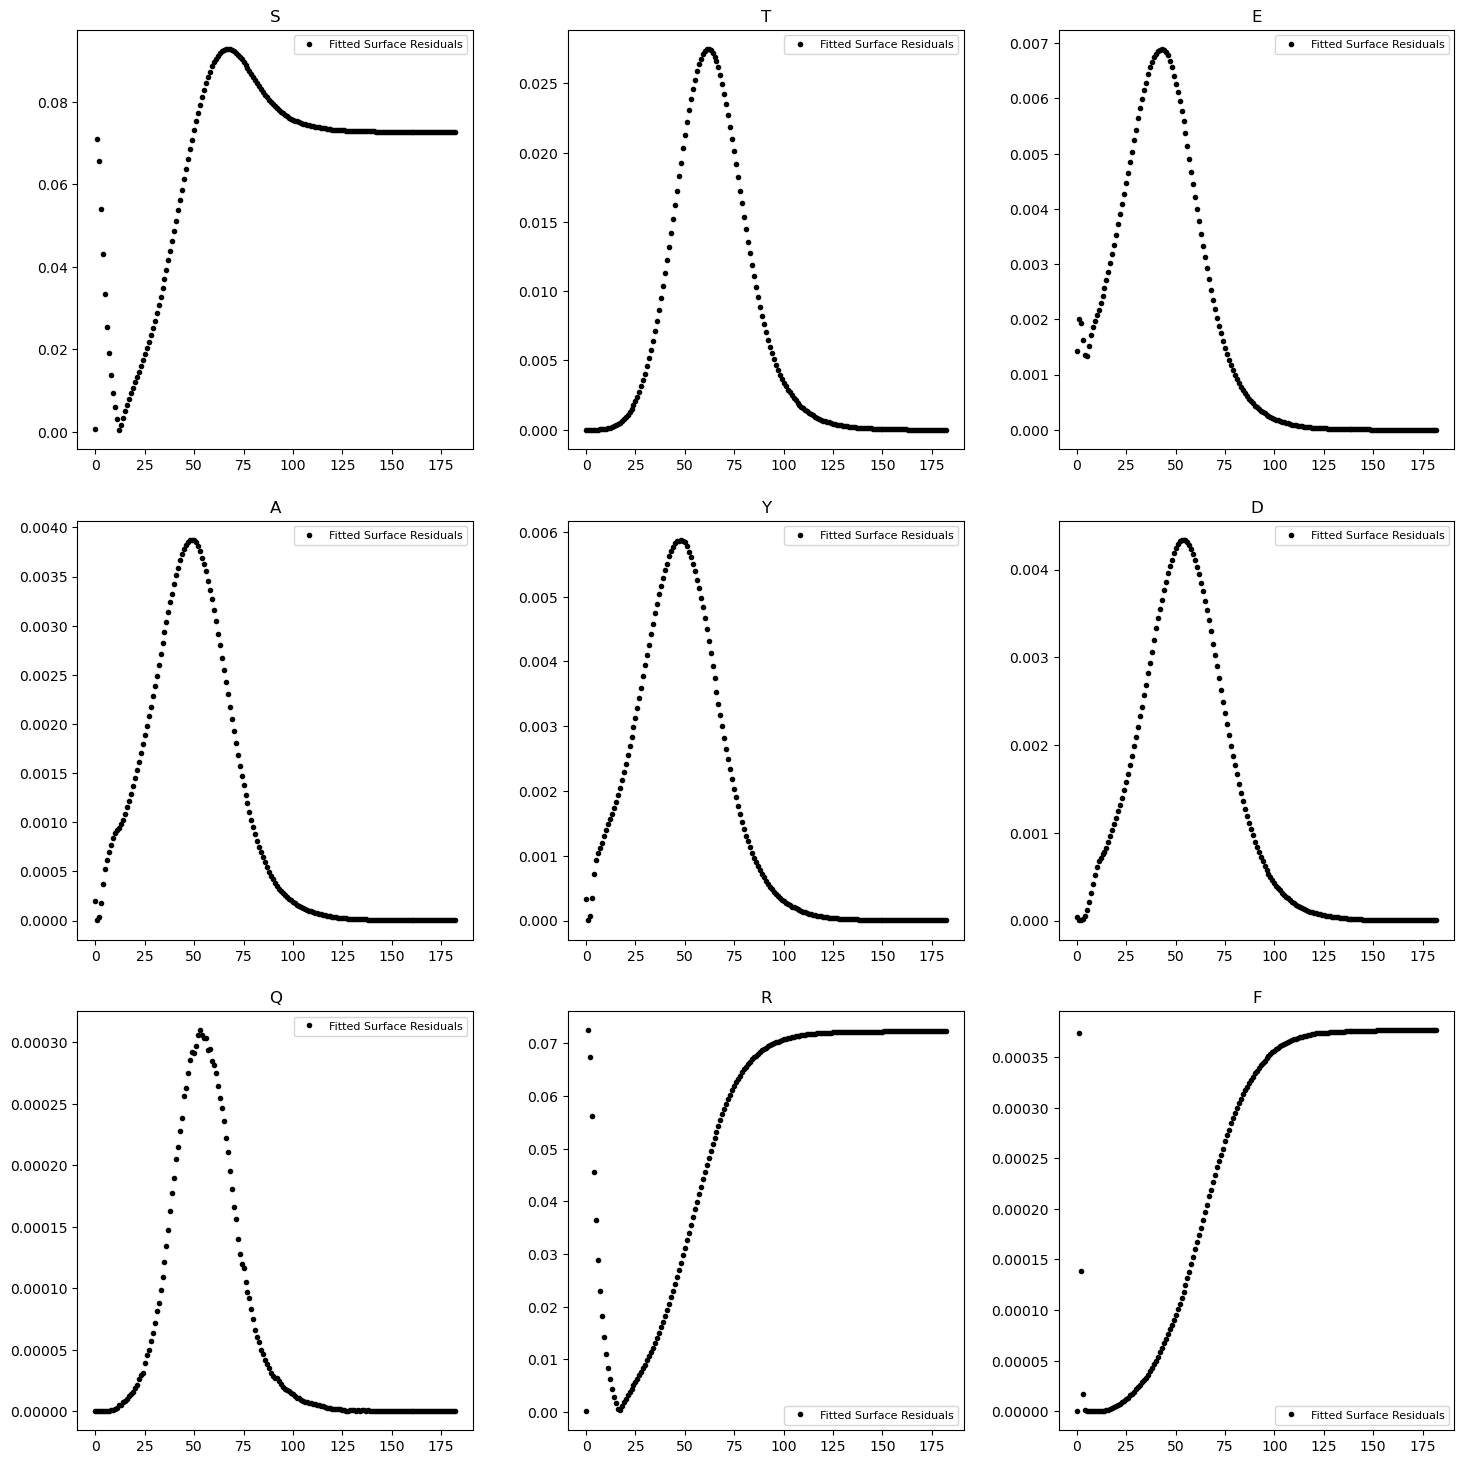

In [25]:
plot=True
if plot:
    n = data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, residuals[:, i - 1], '.k', label='Fitted Surface Residuals')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '_comp_res' + '.png') )
        # plt.show()

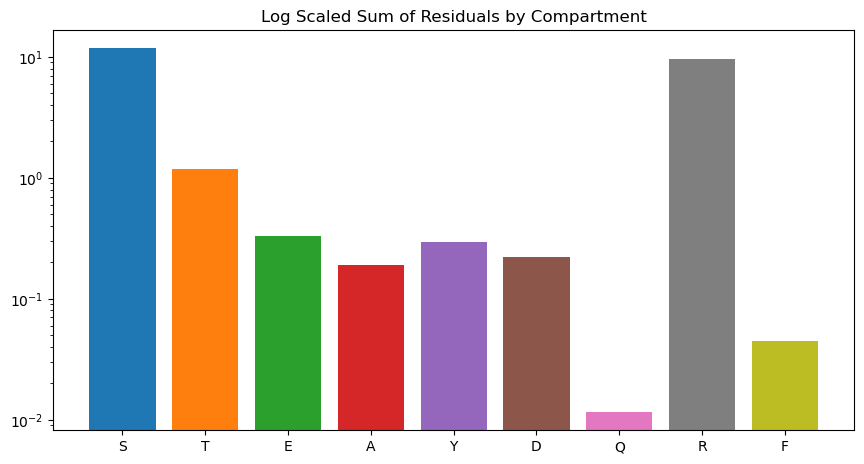

In [26]:
plot=True
if plot:
    n = data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    plt.figure(figsize=(9, 5))
    plt.title('Log Scaled Sum of Residuals by Compartment')
    plt.xticks(np.arange(1, len(col_names)+1), col_names)
    for i in range(1, n + 1):
        plt.bar(i, res_sum[i-1], log=True)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '_comp_res_bar' + '.png') )
        # plt.show()